# Dynamic Model Example

## Car repair

### The Gotham Taxi Company has a fleet of 500 taxicabs. On any given day of use, a taxi has an 0.4% chance of breaking down. Broken-down taxis are towed overnight to the company repair shop. They return to service the day after they are fixed. Each day a taxi spends in the shop costs the company $350 in lost profits. There are three mechanics Gotham is considering hiring to work in the repair shop: Larry, Moe and Curly. Each can fix one to three taxis per day.

- ### Larry would cost the company $300 per day. On any given day, there is 20% probability he can only fix one taxi, and a 40% probability he will be able to fix either two or three.

- ### Moe costs $250 per day. He has an equal probability of being able to fix either one, two, or three taxis on any given day.

- ### Curly costs $200 per day. On any given day, there is a 50% chance he can fix only one cab, a 30% chance he will be able fix two, and a 20% chance that he will be able to fix three.

### The company may hire any combination of the three mechanics: any one, any two, or all three. **Explain why you can tell, prior to performing any simulation, that the option of hiring just Curly will not be workable. Explain this Simulate each possibility by **200 trials of 100 days\*\* each. Which possibility gives them the lowest average cost? What is the average number of taxis in the shop when you adopt this policy?


In [1]:

import numpy as np
import pandas as pd
import scipy.stats as stats  # prefered
# from scipy.stats import binom, rv_discrete, poisson, norm, expon # you may NOT use them directly, stats.binom is suggested.
import matplotlib.pyplot as plt
from itertools import product


In [2]:
# Create the assign matrix for mechanics


def assign_matrix(*cols):
    '''
    Assigns a 0-1 matrix for each cols
    '''
    matrix_0_1 = list(product([0, 1], repeat=len(cols)))
    return pd.DataFrame([*matrix_0_1], columns=cols)


In [3]:
hr_df = assign_matrix('Larry', 'Curly', 'Moe')
hr_df


,Larry,Curly,Moe
0,0,0,0
1,0,0,1
2,0,1,0
3,0,1,1
4,1,0,0
5,1,0,1
6,1,1,0
7,1,1,1


In [4]:
# drop the senario  [0 0 0], which means no one hired.

hr_df.drop(hr_df.iloc[:1].index, inplace=True)

hr_df.reset_index(drop=True, inplace=True)


In [5]:
# calcualte the wage for mechanics in different senarios
wage = [300, 200, 250]
hr_wage = hr_df.dot(wage)

cost_mechanics = hr_wage * 101
cost_mechanics


0    25250
1    20200
2    45450
3    30300
4    55550
5    50500
6    75750
dtype: int64

In [6]:
# generate repaired cars random variable for each mechanic
def repairs(names, cars, probs, days=101):
    repair_dict = {name: stats.rv_discrete(values=(car, prob)).rvs(
        size=days) for name, car, prob in zip(names, cars, probs)}

    return pd.DataFrame(repair_dict)


# import the parameters of each mechanic
names = ('Larry', 'Curly', 'Moe')
cars = ((1, 2, 3), (1, 2, 3), (1, 2, 3))
probs = ((0.2, 0.4, 0.4), (1 / 3, 1 / 3, 1 / 3), (0.5, 0.3, 0.2))

repair_df = repairs(
    names, cars,
    probs)  # generate the repairing cars random variable for each mechanic


In [7]:
repair_7 = repair_df.dot(hr_df.T).to_dict(
)  # combine the repairing cars random variable of each mechanic with the assignment matrix

repair_7['cars_broken'] = stats.binom(n=500, p=0.004).rvs(
    size=101)  # generate the number of broken cars every day


In [8]:
# make the day start and end labels for the scenarios
ls_end = []
ls_start = []
for i in range(7):
    ls_end.append(f"{i}_end")
    ls_start.append(f"{i}_start")


In [9]:
# Build the simulation function with Python Dictionary approach (fast while take more Memory)


def repairTrials_dic():
    """initialize the simulation"""
    days = 101  # from day 0 to day 100

    # initialize every day start and end status with zero arrays
    for i, j in zip(ls_start, ls_end):
        repair_7[i] = np.zeros(days).astype(dtype=int)
        repair_7[j] = np.zeros(days).astype(dtype=int)
    """calculate the repir shop status at the start and end of each day"""
    for j in zip(ls_start, ls_end, range(7)):
        # j[0]: start day, j[1]: end day, j[2]: 7 scenarios in the repair_7
        for i in range(1, days):
            repair_7[j[0]][i] = repair_7[j[1]][i -
                                               1] + repair_7['cars_broken'][i -
                                                                            1]
            # the number of cars to be repaired at the start of the day is determined by the sum of the number of broken cars  at the end of the previous day and the number of cars at the repair shop at the end of the previous day

            repair_7[j[1]][i] = np.maximum(
                (repair_7[j[0]][i] - repair_7[j[2]][i]), 0)
            # the number of broken cars at the end of the day is mainly determined by subtracting the number of cars can be repaired by the mechanic(s) from the number of cars to be repaired at the start of the day,however, is the number of subtraction is negative, which means the mechanic(s) can repair more cars than that in the day beginning, so the number of broken cars at the end of the day is zero, all cars are repaired.

    sum_start = [
        repair_7[ls].sum() for ls in ls_start
    ]  # calculate the sum of the number of cars to be repaired at the start of the day
    """calculate the total cost of each scenario"""

    car_in_repair = [
        sum_start[i] / 100 for i in range(7)
    ]  # avergae the number of cars to be repaired at the start of the day
    cost_no_service = [sum_start[i] * 350 for i in range(7)
                       ]  # calculate the  no service cost of broken cars

    total_cost = cost_mechanics + cost_no_service
    # calculate the total cost of each scenario

    return total_cost, car_in_repair


In [10]:
# Make the simulation for 1000 times, then calculate the mean cost of each scenario
repairTrials_cost_ls = [repairTrials_dic()[0].values for _ in range(1000)]
mean_cost_ls = np.mean(repairTrials_cost_ls, axis=0)
mean_cost_ls


array([479900., 176300., 114750., 128300., 122050., 114900., 139450.])

In [11]:
# calculate the mean number of cars to be repaired at the start of the day
car_in_repair_ls = np.empty(shape=(1000, 7))

for i in range(1000):
    car_in_repair_ls[i] = repairTrials_dic()[1]

mean_repair_ls = np.mean(car_in_repair_ls, axis=0)
mean_repair_ls


array([12.99,  4.46,  1.98,  2.8 ,  1.9 ,  1.84,  1.82])

### Visualization


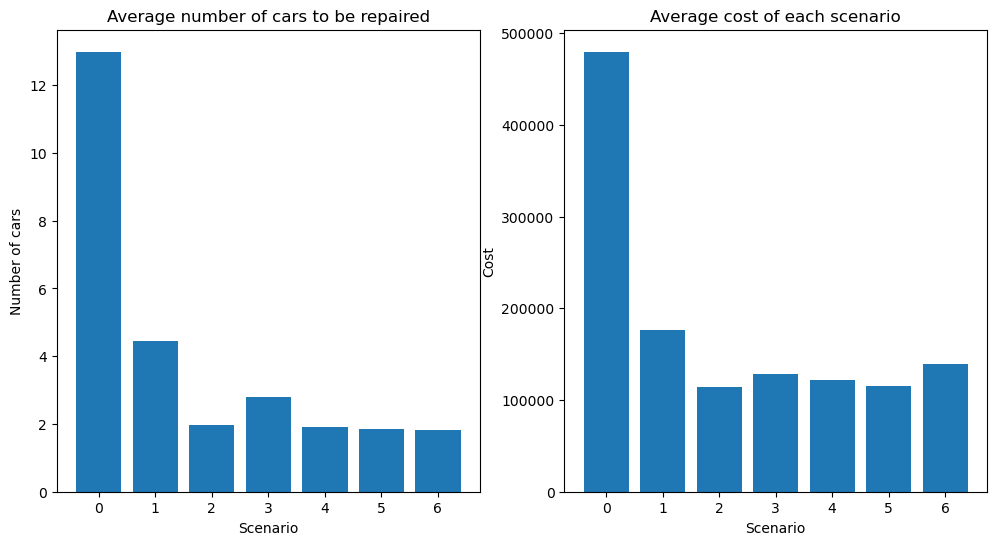

In [12]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(range(7), mean_repair_ls)
axes[0].set(title='Average number of cars to be repaired',
            xlabel='Scenario',
            ylabel='Number of cars')

axes[1].bar(range(7), mean_cost_ls)
axes[1].set(title='Average cost of each scenario',
            xlabel='Scenario',
            ylabel='Cost')

plt.show()


In [13]:
sol = np.argmin(mean_cost_ls)
candidates = hr_df.columns[hr_df.loc[sol] == 1].tolist()

print(
    f"\nSo as the plots shows above the solution wiht lowes cost is the scenario {sol}, with the cost of ${mean_cost_ls[sol]}.\nMeanwhile the average number of cars in repair is {mean_repair_ls[sol].round(2)}.\nIn this scenario, the assign_matrix shows: \n{hr_df.loc[sol]==1},which means that {candidates} should be hired."
)



So as the plots shows above the solution wiht lowes cost is the scenario 2, with the cost of $114750.0.
Meanwhile the average number of cars in repair is 1.98.
In this scenario, the assign_matrix shows: 
Larry    False
Curly     True
Moe       True
Name: 2, dtype: bool,which means that ['Curly', 'Moe'] should be hired.
